<h1>VQ-GAN</h1>
Rough idea: Autoencode an input image, here demonstrated on [3 x 128 x 128] images, but express the latent code not as continous values,<br/>
but as quantised values (i.e. indices in a codebook).<br/>
Technically, this is pretty similar to applying K-means to the latent space, with the centroid being the "codewords"; we then simply round the codewords to the nearest centroid.<br/>
The big change from VQGAN to VQ-VAE is an additional discriminator: The output is checked by another network that tries to tell apart input and output, and hence teaches the VQGAN to output something that looks plausible. Examplary: For a fish, the scales are "refined" by inventing new details instead of just giving the average colour for the scales. These might not look exactly like the input, but plausible.<br/>
<br/>
Applications for this include e.g. autoregressive probabilistic generation.
<br/>
Literature I recommend:<br/>
1. VQ-VAE:  https://arxiv.org/abs/1711.00937<br/>
2. VQGAN: https://arxiv.org/abs/2012.09841<br/>
3. Improved VQGAN: https://arxiv.org/abs/2310.05400 <br/>

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import time
import torch.nn as nn
import math
import numpy as np
from torchvision.utils import save_image
import platform
import sys
import os
import matplotlib.pyplot as plt
import torchvision

#nobody likes scientific rep...
torch.set_printoptions(precision=6, sci_mode=False)

In [ ]:
VQVAE_D = 64 #number of dimensions in quantised space, i.e. the number of dimensions in which we cluster (round in [b x VQVAE_D x W X H] in dimension 1 to the nearest centroid (i.e. codeword))
# rule of thumb: VQVAE_D should be at least such that CODEWORDS <= 2**VQVAE_D to ensure that the quantised space is large enough to capture the variance in the data;
# trivial example: if we use VQVAE_D = 1, then we can only cluster the data in one dimension, which doesn't work that well as networks are good at doing binary decisions, but not good at doing decisions with 512 different options
# if we use e.g. 4 dimensions, then we can do 4 binary decisions with our relus, hence we have 16 different options - better than 1, but still not enough for 512 different options (=CODEWORDS)
VQVAE_K = 512 #number of codewords in the codebook, i.e. the number of centroids in the quantised space

#number of channels for both discriminator/autoencoder
#if you want the model to be more powerful, I'd rather add more layers than more channels here
#e.g. replace the convs with full residual blocks 
CHANNELS = 256

<h1>1. Dataloader</h1>
To have something simple to test, we can also just use CIFAR in an upscaled version here; Consider this if you do not have e.g. ImageNet on your drive available to you

In [2]:
if False: ### <--- set to True if you DO have ImageNet!
    print("Loading ImageNet...")
    transform = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
    ])
    IMAGENET_PATH = "path_to_imagenet_folder"
    data_train = ImageFolder(IMAGENET_PATH+'/train/',  transform=transform)
    data_test = ImageFolder(IMAGENET_PATH+'/val/',  transform=transform)
else:
    #resize CIFAR to 128x128
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((128, 128))]) 
    data_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    data_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

bsize = 8

trainloader = DataLoader(data_train, batch_size=bsize, shuffle=True, num_workers=10, pin_memory=False)
testloader = DataLoader(data_test, batch_size=bsize, shuffle=True, num_workers=10, pin_memory=False)
print("Done loading Data!")

Loading ImageNet...
Done loading ImageNet!


<h1>2. Networks</h2>

In [4]:
#simple discriminator: just take the image, do a few layers of convolution and downscaling, then use patchwise output as score for the discriminator
#i.e. the resulting output image, for 128-by-128 input, is now 16-by-16 values that all should be 1/-1 (real/fake)
class Discriminator(nn.Module):
    def __init__(self, c_in):
        super(Discriminator, self).__init__()

        self.relu = torch.nn.LeakyReLU(0.2) #we use leaky relu as activation function, as it also has a gradient for an input < 0; use slope=0.2 for better gradient flow
        self.reduce = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.res_1 = torch.nn.Conv2d(in_channels=c_in, out_channels=CHANNELS, kernel_size=1, stride=1, padding=0)
        self.res_2 = torch.nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=1, stride=1, padding=0)
        self.res_3 = torch.nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=1, stride=1, padding=0)

        self.conv_1 = torch.nn.Conv2d(in_channels=c_in, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1)
        self.conv_3 = torch.nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1)
        self.conv_4 = torch.nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1)
        self.conv_5 = torch.nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1)
        self.conv_6 = torch.nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1)
        self.conv_7 = torch.nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1)
        self.conv_8 = torch.nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1)
        self.conv_9 = torch.nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x_res_1 = self.res_1(x)

        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x + x_res_1

        x = self.reduce(x)
        x_res_2 = self.res_2(x)
        x = self.relu(x)

        x = self.relu(self.conv_4(x))
        x = self.relu(self.conv_5(x))
        x = self.relu(self.conv_6(x))
        x = x + x_res_2

        x = self.reduce(x)
        x_res_3 = self.res_3(x)
        x = self.relu(x)

        x = self.relu(self.conv_7(x))
        x = self.relu(self.conv_8(x))
        x = x + x_res_3
        x = self.relu(self.conv_9(x))

        return x

torch.Size([2, 256, 32, 32])

In [5]:
#simple convolutional autoencoder: take the input, process with convolution, relu, then downscale and repeat; then quantise; then bring back to original size
class BaseAE(nn.Module):
    def __init__(self, c_in):
        super(BaseAE, self).__init__()

        self.relu = torch.nn.LeakyReLU() #we use leaky relu as activation function, as it also has a gradient for an input < 0
        self.reduce = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.conv_res = torch.nn.Conv2d(in_channels=c_in, out_channels=VQVAE_D, kernel_size=1, stride=1, padding=0, bias=False)

        #super basic encoder (convolution -> relu -> pooling -> repeat), to improve: replace conv2d with a full residual block and add some normalisation
        #we don't use strided convolution to reduce the spatial dimensions, but instead use pooling, as this usually avoids checkerboard artefacts: https://distill.pub/2016/deconv-checkerboard/
        self.encoder = nn.Sequential()
        self.encoder.append(torch.nn.Conv2d(in_channels=c_in, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1))
        self.encoder.append(self.relu)
        self.encoder.append(self.reduce)
        self.encoder.append(torch.nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1))
        self.encoder.append(self.relu)
        self.encoder.append(self.reduce)
        self.encoder.append(torch.nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1))
        self.encoder.append(self.relu)
        self.encoder.append(self.reduce)
        self.encoder.append(torch.nn.Conv2d(in_channels=CHANNELS, out_channels=VQVAE_D, kernel_size=3, stride=1, padding=1))
        
        #same for the decoder, but with upsampling instead of pooling. same as above, no transposed convolutions, but upsampling, as this usually avoids checkerboard artefacts
        self.decoder = nn.Sequential()
        self.decoder.append(torch.nn.Conv2d(in_channels=VQVAE_D, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1))
        self.decoder.append(self.relu)
        self.decoder.append(torch.nn.Upsample(scale_factor=2, mode='bilinear'))
        self.decoder.append(torch.nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1))
        self.decoder.append(self.relu)
        self.decoder.append(torch.nn.Upsample(scale_factor=2, mode='bilinear'))
        self.decoder.append(torch.nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=3, stride=1, padding=1))
        self.decoder.append(self.relu)
        self.decoder.append(torch.nn.Upsample(scale_factor=2, mode='bilinear'))
        self.decoder.append(torch.nn.Conv2d(in_channels=CHANNELS, out_channels=c_in, kernel_size=3, stride=1, padding=1))
        self.decoder.append(self.relu) #we have [0, 1] for our data (not [-1, 1]), so we CAN use a relu; if we'd normalise data, this would kill of negative values (which we don't have)

        #this is the values we round to, i.e. the "centroids" in the quantised space
        #little trick to get better initialisation:
        #   if we get values far away from any encoder outputs by chance, we have no gradient to these codewords
        #   hence, rather set the codewords a bit "closer" around the centre, so we have a gradient for all codewords 
        self.codebook = torch.nn.Parameter((torch.rand(VQVAE_K, VQVAE_D) * 2.0 - 1.0) * 0.5, requires_grad=True)

    def quantise(self, x):
        #this is where the magic happens:
        #    1. take input of size [b x W x H x VQVAE_D] and reshape to [b x W x H x VQVAE_D];
        #       this means we have ALL the codewords in the last dimension now, so we can just merge together all other dimensions to easily compare them to the codewords
        x = x.permute(0, 2, 3, 1).contiguous()
        size_in = x.size()
        x = x.view(-1, VQVAE_D)
        #   2. compare [b*W*H x VQVAE_D] to [CODEWORDS x VQVAE_D]: by re-shaping to have [b*W*H x 1 x VQVAE_D] and [1 x CODEWORDS x VQVAE_D], the substraction will
        #      give us a [b*W*H x CODEWORDS X VQVAE_D] tensor of all distance pairs between input elements (b*W*H) and the CODEWORDS-many codewords; just square, 
        #      then sum up the last dimension to get sum of the distance values for each dimension (=euclidean squared distance)
        #      and then take the argmin to get the index of the closest codeword for each input element - these are our indices we want!
        indices = (x[:,None] - self.codebook.view(1, VQVAE_K, VQVAE_D)).square().sum(dim=2).argmin(dim=1)
        #   3. we take those indices we just looked up: these are the indices of the closest codeword for each input element, so we can now look up the actual 
        #      codeword to find the closest codeword to each input element aka the "centroids" we round to
        x_rounded = self.codebook[indices]
        
        #   4. we calculate the loss for the commitment loss (i.e. does the encoder produce stuff from the codebook?) and the codebook loss (how close is the codebook to the encoder outputs?)
        #      the value is exactly the same for both terms, but this way we can a) train encoder and codebook with different magnitudes and b) the encoder outputs and codebook outputs are
        #      not just "shrinked" to one super tiny value: the loss we be almost zero if codebook and encoder outputs would be just downscaled by some tiny factor (latent space just shrinks together)
        #      to avoid that, we use the detach() function, making sure that codebook and encoder outputs move individually and not just shrink together to something tiny
        loss_commitment = (x - x_rounded.detach()).square().mean() #only have gradient for encoder 
        loss_codebook   = (x.detach() - x_rounded).square().mean()   #only have gradient for codebook

        #   5. the actual rounding we do: we take the difference between the rounded and the unrounded value and add it to the unrounded value
        #      the paper calls this "straight through estimator", as we just pass the gradient through the rounding operation (which is not differentiable)
        #      what essentially happens here is that we just take our x and substract some float without any gradient, similar to writing "x = x - 0.1":
        #      "(x - x_rounded).detach()" becomes just some number that we substract from x; this converts x to the same values as x_rounded, but the gradient is not passed through this operation
        #      i.e. we round, but keep the (then a bit inexact) gradient 
        x = x - (x - x_rounded).detach() #change x to x_rounded, but keep the gradient from x

        #   6. we reshape back to the original shape and return the values; we also return both losses and the indices of the closest codewords
        x = x.view(size_in)
        x = x.permute(0, 3, 1, 2).contiguous()
        return x, loss_codebook, loss_commitment, indices.view(x.size()[0], x.size()[2], x.size()[3])
    
    def forward(self, x):
        #encode, then quantise, then decode; pass the codebook loss and commitment loss through so we can use them for training
        w, h = x.size()[2], x.size()[3]
        x_res = self.conv_res(self.reduce(self.reduce(self.reduce(x)))) #simple residual connection; makes optimisation more stable
        x = self.encoder(x)
        x = x + x_res
        x, loss_codebook, loss_commitment, indices = self.quantise(x)
        x = self.decoder(x)
        return x, loss_codebook, loss_commitment, indices

<h1>(Helpers)</h1>

In [6]:
def imshow(img):
    #check if is in interactive session:
    if 'ipykernel' in sys.modules:
        npimg = img.clamp(0.0, 1.0).numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

#make directory:
if not os.path.exists("vqvae"):
    os.makedirs("vqvae")
if not os.path.exists("vqgan"):
    os.makedirs("vqgan")

<h1>Training</h1>

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /local/telsner/anaconda3/envs/ldm/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
CONV NET HAS  2702595  PARAMS
DISC NET HAS  4860416  PARAMS
SWITCH GAN ON
SWITCH GAN OFF
*** DONE WITH EPOCH  0 ***


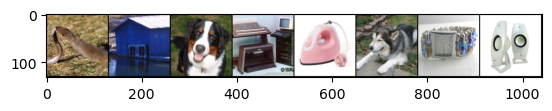

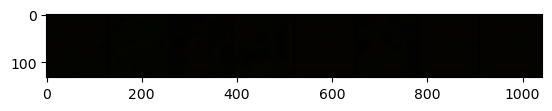

	Discriminator loss:  0.2935469150543213
	Rec loss:  0.34434150010347364
	Distribution loss:  0.0004307696998119354
SWITCH GAN ON
*** DONE WITH EPOCH  1 ***


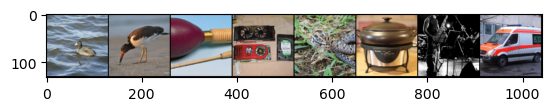

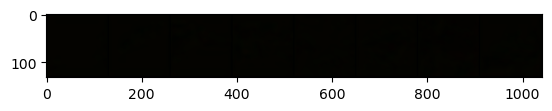

	Discriminator loss:  0.1873463683082067
	Rec loss:  0.4859392009298647
	Distribution loss:  0.0003895301957828371


KeyboardInterrupt: 

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = BaseAE(c_in=3).to(DEVICE)
EPSILON = 0.00001

import lpips
#lpips is a network-based loss metric that considers how similar the output is not in terms of pixelwise loss, but in terms of how it is represented in the deeper layers of an already trained network
#the idea is that tiny differences, e.g. a feature that's shifted slightly, should not be punished as harshly / visible artifacts like boundaries between patches SHOULD be punished
hinge = nn.ReLU()
loss_fn_perceptual = lpips.LPIPS(net='vgg').to(DEVICE)
discriminator = Discriminator(3).to(DEVICE)

print("VQGAN has ", sum(p.numel() for p in net.parameters() if p.requires_grad), " PARAMS")
print("Discriminator has ", sum(p.numel() for p in discriminator.parameters() if p.requires_grad), " PARAMS")

#classic GAN setup: our generator here is just the autoencoder
optim_generator = torch.optim.AdamW(net.parameters(), lr=0.0002, weight_decay=0.01)
optim_discriminator = torch.optim.AdamW(discriminator.parameters(), lr=0.0002, weight_decay=0.01)
APPLY_GAN = False #only start applying the discriminator after ~5000 epochs; else, training is super unstable because we try to "sharpen" patches that aren't even showing anything useful yet
best = None
total_its = 0
for epoch in range(0, 100000):
    avg_losses = [[0.0, 0.0], 0.0]
    its = 0
    for data, _ in trainloader:
        data = data.to(DEVICE)
        
        #alternate training generator and discriminator every iteration

        # train the discriminator
        if APPLY_GAN and total_its % 2 == 1:
            optim_discriminator.zero_grad()

            discriminator.train(True)
            net.train(False)
            
            output = net(data)[0]
            
            out_real = discriminator(data)
            out_generated = discriminator(output)
            
            #real should be 1.0, generated should be -1.0
            loss_discriminator = 0.5 * (hinge(1.0 - out_real).mean() + hinge(1.0 + out_generated).mean())
            avg_losses[1] += loss_discriminator.item()
            loss_discriminator.backward()
            optim_discriminator.step()
        else:
        #train the generator, i.e. the autoencoder
            optim_generator.zero_grad()

            discriminator.train(False)
            net.train(True)
            
            output, loss_codebook, loss_commitment, indices = net(data)

            if APPLY_GAN:
                #reconstruction loss after the first 5000 epochs is a mix between perceptual loss (lpips) and L1 loss
                #L1 loss to not be strongly biased to perfect reconstruction, e.g. features are allowed to be slightly offset
                loss_reconstruction = loss_fn_perceptual(output, data).mean()
                loss_l1 = (output - data).abs().mean()
                loss_reconstruction = loss_reconstruction + loss_l1
            else:
                #use a simple L2 loss to make sure out autoencoder does learn something useful before going for the discriminator to "sharpen" 
                loss_reconstruction = (output - data).square().mean()

            avg_losses[0][0] += loss_reconstruction.item()

            #additional regularisation: make sure our codebook values are evenly distributed
            #we don't need this, but it helps a lot and is just two lines
            #this is NOT original VQ-VAE/VQGAN code, but I found this helpful for better codebook useage; unused codebook entries mean reduced quality
            normal_distr = torch.randn(VQVAE_K, VQVAE_D, device=DEVICE)
            loss_distrib = (net.codebook[:,None] - normal_distr[None]).square().mean(dim=2).min(dim=1)[0].mean()

            avg_losses[0][1] += loss_distrib.item() * 0.001

            loss_vq = (loss_codebook * 0.25 + loss_commitment)
            #loss is then a compoud: reconstruction loss plus VQ-VAE losses (anything regarding the codebook) and the distribution loss to make sure we have good codebook uesage
            loss = loss_reconstruction + loss_vq + 0.001 * loss_distrib
            
            #if we're past the initial 5000 warmup iterations, we apply the discriminator & try to fool it:
            if APPLY_GAN:
                loss_gan = -(discriminator(output)).mean()

                #we need the following bit to BALANCE the GAN loss:
                #  these lines essentially make sure the magnitude of the GAN loss is proportional to the magnitude of the reconstruction loss
                #  otherwise, training with little reconstruction loss will have high GAN loss, which is unstable --> rather have both at roughly the same magnitude
                loss_rec_grads = torch.autograd.grad(loss_reconstruction, net.decoder[-2].weight, retain_graph=True)[0]
                loss_gan_grads = torch.autograd.grad(loss_gan, net.decoder[-2].weight, retain_graph=True)[0]
                gan_lambda = 0.75 * torch.norm(loss_rec_grads) / torch.norm(loss_gan_grads + EPSILON)
                gan_lambda = gan_lambda.detach()
            
                loss = loss + gan_lambda * loss_gan

            loss.backward()
            optim_generator.step()

        #especially for larger datasets like imagenet, we don't want to wait forever to see something :)
        its += 1
        if its == int(len(trainloader) / 10):
            break
        total_its += 1

        #switch the GAN on after our "warmup" of just doing reconstruction; this is for stability purposes 
        if total_its > 5000:
            if not APPLY_GAN:
                print("SWITCH GAN ON")
            APPLY_GAN = True
        else:
            if APPLY_GAN:
                print("SWITCH GAN OFF")
            APPLY_GAN = False

    print("*** DONE WITH EPOCH ", epoch, "***")

    #computing a classic reconstruction loss does not make sense here:
    #   we actively encourage our network to "invent" high-frequency details!
    #   hence, just output stuff. if you really want to measure, you could use e.g. FID.
    #   however, this takes quite long... 
    with torch.no_grad():
        for data, _ in testloader:
            data = data.to(DEVICE)
            output = net(data)[0]
            #show image:
            torchvision.utils.save_image(torchvision.utils.make_grid(data.cpu()), "vqgan/"+str(epoch)+"_in.png")
            torchvision.utils.save_image(torchvision.utils.make_grid(output.cpu()), "vqgan/"+str(epoch)+"_out.png")
            imshow(torchvision.utils.make_grid(data.cpu().detach()).cpu().detach())
            imshow(torchvision.utils.make_grid(output.cpu().detach()).cpu().detach())
            break
        print("\tDiscriminator loss: ", avg_losses[1] / its)
    print("\tRec loss: ", avg_losses[0][0] / its)
    print("\tDistribution loss: ", avg_losses[0][1] / its)
    
    torch.save(net.state_dict(), "nets/vqgan_"+str(epoch)+".net")